In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from network import Approx, Lagrange, objective

load from checkpoint with iters:  110000


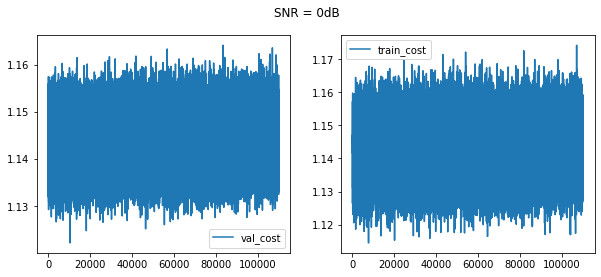

load from checkpoint with iters:  110000


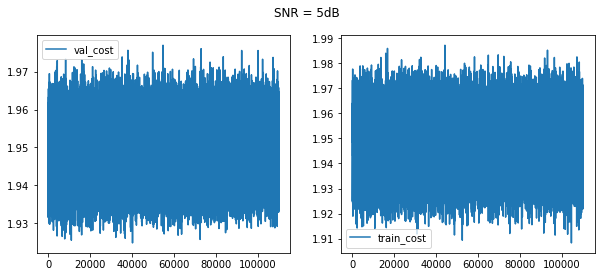

load from checkpoint with iters:  110000


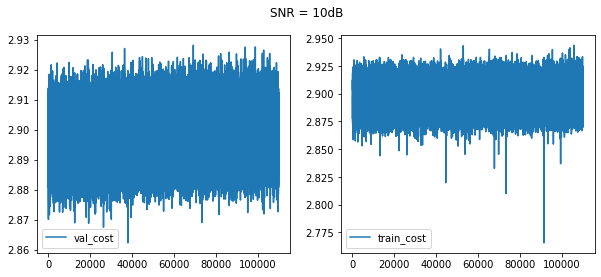

load from checkpoint with iters:  110000


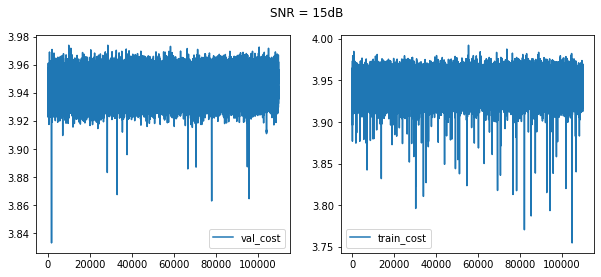

load from checkpoint with iters:  100000


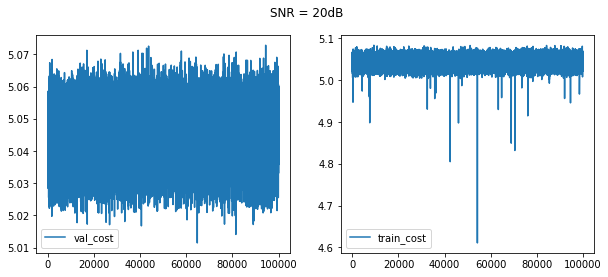

load from checkpoint with iters:  110000


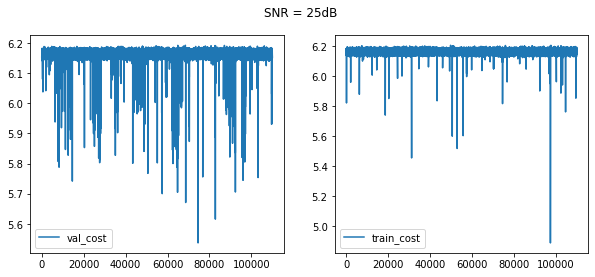

load from checkpoint with iters:  110000


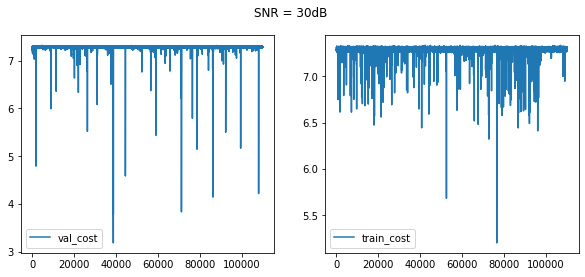

In [2]:
SNR= [0, 5, 10, 15, 20, 25, 30]
save_path = ['./SNR_0_quick', './SNR_5_quick', './SNR_10_quick', './SNR_15_quick', './SNR_20_quick', './SNR_25_quick', \
             './SNR_30_quick', ]
iter_ = [61000, 185000, 190000, 410000, 1190000, 2900000, 3260000, ]
os.environ['CUDA_VISIBLE_DEVICES']='3'

N = 3
val_batch_size = int(1e6)
val_sample_num = val_batch_size
total_iters = int(5e6)

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    
y1 = np.zeros(total_iters)
y2 = np.zeros(total_iters)
for i in range(len(SNR)):
    lastest_model, lastest_iters = get_lastest_model(path = save_path[i])
    if lastest_model is not None:
        iters = lastest_iters
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        y1[0:iters] = checkpoint['val_cost'][0:iters]
        y2[0:iters] = checkpoint['train_cost'][0:iters]
        print('load from checkpoint with iters: ', iters)

        x = np.arange(iters)
        
        fig,axes = plt.subplots(1,2,figsize=(10,4))
        
        ax1=axes[0]
        ax1.plot(x,y1[0:iters], label = 'val_cost')
#         ax1.plot(x[iter_[i]:iters],y1[iter_[i]:iters], label = 'val_cost')
        ax1.legend(loc='best')
        
        ax2 = axes[1]
        ax2.plot(x,y2[0:iters], label = 'train_cost')
        ax2.legend(loc='best')
        
        fig.suptitle('SNR = '+ str(SNR[i]) + 'dB')
        plt.show()

Data Generating Finished!


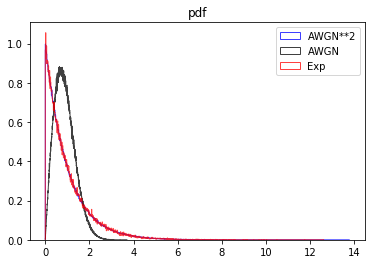

In [3]:

h_exp = torch.zeros(int(1e5))
h_exp.exponential_(lambd=1)
val_path = get_dataset(path = './datasets', name = 'val.pth.tar')
h_val_dataset = torch.load(val_path, map_location='cpu')['val_dataset']
print('Data Generating Finished!')

showing = False
plt.plot()
plt.hist(h_val_dataset.reshape(-1),1000,density = True,histtype='step',color='b', facecolor='b',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'AWGN**2')
plt.hist(np.sqrt(h_val_dataset.reshape(-1)),1000,density = True,histtype='step',color='k', facecolor='k',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'AWGN')
plt.hist(h_exp.data.cpu().numpy(),1000,density = True,histtype='step',color='r', facecolor='k',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'Exp')
plt.title("cdf" if showing else "pdf")
plt.legend(loc='best')
plt.show()

Data Generating Finished!
load from checkpoint with SNR:  0
load from checkpoint with SNR:  0
load from checkpoint with iters:  110000
load from checkpoint with SNR:  5
load from checkpoint with SNR:  5
load from checkpoint with iters:  110000
load from checkpoint with SNR:  10
load from checkpoint with SNR:  10
load from checkpoint with iters:  110000
load from checkpoint with SNR:  15
load from checkpoint with SNR:  15
load from checkpoint with iters:  110000
load from checkpoint with SNR:  20
load from checkpoint with SNR:  20
load from checkpoint with iters:  100000
load from checkpoint with SNR:  25
load from checkpoint with SNR:  25
load from checkpoint with iters:  110000
load from checkpoint with SNR:  30
load from checkpoint with SNR:  30
load from checkpoint with iters:  110000


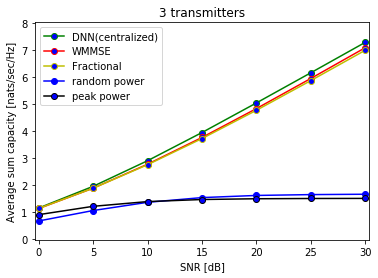

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [4]:
val_path = get_dataset(path = './datasets', name = 'val.pth.tar')
h_val_dataset = torch.load(val_path, map_location='cpu')['val_dataset']
print('Data Generating Finished!')

cap1 = [None]*len(save_path)
cap2 = [None]*len(save_path)
cap3 = [None]*len(save_path)
cap_rand = [None]*len(save_path)
cap_peak = [None]*len(save_path)
for i in range(len(SNR)):
    lastest_model, lastest_SNR = get_lastest_model(path = "./WMMSE_SNR", exact = "%07d"%(SNR[i]))
    p_WMMSE = None

    if lastest_model is not None:
        iters = lastest_SNR
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        p_WMMSE = checkpoint['power']
        print('load from checkpoint with SNR: ', iters)

    loss1 = objective(torch.from_numpy(p_WMMSE), torch.from_numpy(h_val_dataset))
    cap1[i] = torch.mean(loss1)
    cap_rand[i] = torch.mean(objective(torch.rand(*p_WMMSE.shape)*10**(SNR[i]/10), torch.from_numpy(h_val_dataset)))
    cap_peak[i] = torch.mean(objective(torch.ones(*p_WMMSE.shape)*10**(SNR[i]/10), torch.from_numpy(h_val_dataset)))
    
    lastest_model, lastest_SNR = get_lastest_model(path = "./Frac_SNR", exact = "%07d"%(SNR[i]))
    p_Frac = None

    if lastest_model is not None:
        iters = lastest_SNR
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        p_Frac = checkpoint['power']
        print('load from checkpoint with SNR: ', iters)
    loss3 = objective(torch.from_numpy(p_Frac), torch.from_numpy(h_val_dataset))
    cap3[i] = torch.mean(loss3)
    
    model_Approx = Approx(inp = N**2, oup = N, hidden_dim = 10*N, P = 10**(SNR[i]/10))
    if use_gpu:
        model_Approx = nn.DataParallel(model_Approx)
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model_Approx = model_Approx.to(device)
    lastest_model, lastest_iters = get_lastest_model(path = save_path[i])
    if lastest_model is not None:
        iters = lastest_iters
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        model_Approx.load_state_dict(checkpoint['state_approx_dict'], strict=True)
        print('load from checkpoint with iters: ', iters)

    approx = None
    model_Approx.eval()
    with torch.no_grad():
        h_data = torch.from_numpy(h_val_dataset).to(device)
        approx = model_Approx(h_data)

    loss2 = objective(approx.to('cpu'), torch.from_numpy(h_val_dataset))
    cap2[i] = torch.mean(loss2)
    
plt.plot(SNR, cap2, color='g',markerfacecolor='blue',marker='o', label='DNN(centralized)')
# for a, b in zip(SNR, cap2):  
# #     plt.text(a+1.0, b-0.15, (int(a),round(float(b), 2)),ha='center', va='bottom', fontsize=10)
#     plt.text(a-1.0, b+0.15, round(float(b), 3),ha='center', va='bottom', fontsize=10) 
    
plt.plot(SNR, cap1, color='r',markerfacecolor='blue',marker='o', label='WMMSE')
# for a, b in zip(SNR, cap1):  
# #     plt.text(a+1.0, b-0.15, (int(a),round(float(b), 2)),ha='center', va='bottom', fontsize=10)
#     plt.text(a+1.0, b-0.5, round(float(b), 3),ha='center', va='bottom', fontsize=10)   
    
plt.plot(SNR, cap3, color='y',markerfacecolor='blue',marker='o', label='Fractional')

plt.plot(SNR, cap_rand, color='b',markerfacecolor='blue',marker='o', label='random power')
plt.plot(SNR, cap_peak, color='k',markerfacecolor='blue',marker='o', label='peak power')
    
plt.xlabel('SNR [dB]')
plt.ylabel('Average sum capacity [nats/sec/Hz]')
plt.legend(loc='upper left')
plt.xlim([-0-0.4, 30+0.4])
plt.ylim([0-0.04, 8+0.04])
plt.title("3 transmitters")
fig = plt.gcf()
plt.show()
fig.savefig("./Fig/SRM_to_SNR.eps",format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Data Generating Finished!
load from checkpoint with SNR:  0
load from checkpoint with SNR:  0
load from checkpoint with iters:  110000
DNN:  tensor(1., device='cuda:0')
8.563 %
100000 1.1445379 1.1246663 1.128699 0.6623014 0.8954673


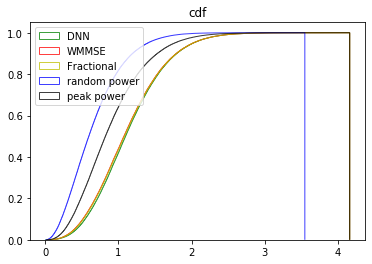

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

load from checkpoint with SNR:  5
load from checkpoint with SNR:  5
load from checkpoint with iters:  110000
DNN:  tensor(3.1623, device='cuda:0')
10.898 %
100000 1.9497892 1.8794246 1.8796023 1.0479097 1.2047708


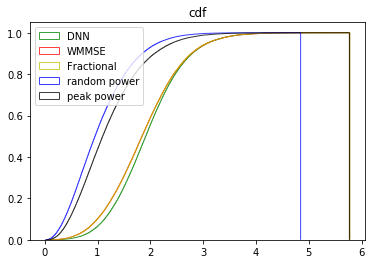

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

load from checkpoint with SNR:  10
load from checkpoint with SNR:  10
load from checkpoint with iters:  110000
DNN:  tensor(10., device='cuda:0')
11.193 %
100000 2.8998985 2.7701497 2.7510393 1.3525585 1.3804077


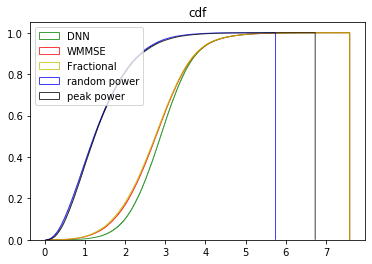

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

load from checkpoint with SNR:  15
load from checkpoint with SNR:  15
load from checkpoint with iters:  110000
DNN:  tensor(31.6228, device='cuda:0')
11.147 %
100000 3.9458869 3.7628589 3.7221012 1.5269805 1.4568803


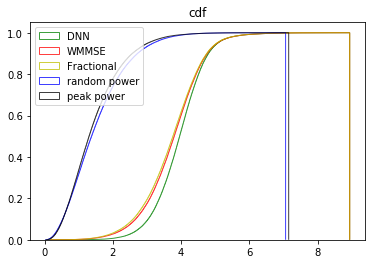

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

load from checkpoint with SNR:  20
load from checkpoint with SNR:  20
load from checkpoint with iters:  100000
DNN:  tensor(100., device='cuda:0')
10.637 %
100000 5.0443935 4.8340816 4.7710342 1.6092006 1.4852537


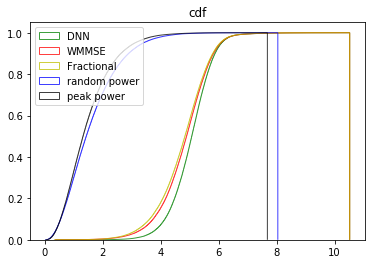

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


load from checkpoint with SNR:  25
load from checkpoint with SNR:  25
load from checkpoint with iters:  110000
DNN:  tensor(316.2278, device='cuda:0')
10.478 %
100000 6.1637106 5.952423 5.8735714 1.6388645 1.4949206


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


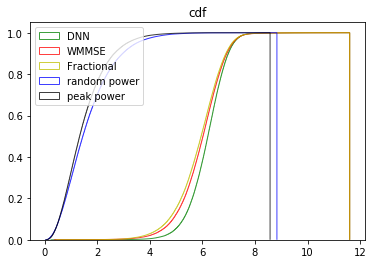

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

load from checkpoint with SNR:  30
load from checkpoint with SNR:  30
load from checkpoint with iters:  110000
DNN:  tensor(1000., device='cuda:0')
9.957 %
100000 7.2930856 7.0936894 6.998922 1.6515547 1.4980816


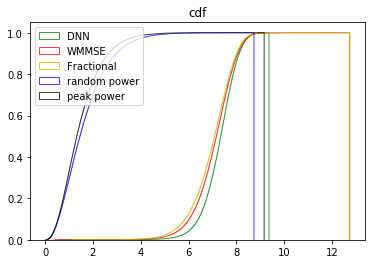

In [5]:
val_path = get_dataset(path = './datasets', name = 'val.pth.tar')
h_val_dataset = torch.load(val_path, map_location='cpu')['val_dataset']
print('Data Generating Finished!')

for i in range(len(SNR)):
    lastest_model, lastest_SNR = get_lastest_model(path = "./WMMSE_SNR", exact = "%07d"%(SNR[i]))
    p_WMMSE = None

    if lastest_model is not None:
        iters = lastest_SNR
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        p_WMMSE = checkpoint['power']
        print('load from checkpoint with SNR: ', iters)
    loss1 = objective(torch.from_numpy(p_WMMSE), torch.from_numpy(h_val_dataset))
    loss4 = objective(torch.rand(*p_WMMSE.shape)*10**(SNR[i]/10), torch.from_numpy(h_val_dataset))
    loss5 = objective(torch.ones(*p_WMMSE.shape)*10**(SNR[i]/10), torch.from_numpy(h_val_dataset))
    
    lastest_model, lastest_SNR = get_lastest_model(path = "./Frac_SNR", exact = "%07d"%(SNR[i]))
    p_Frac = None

    if lastest_model is not None:
        iters = lastest_SNR
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        p_Frac = checkpoint['power']
        print('load from checkpoint with SNR: ', iters)
    loss3 = objective(torch.from_numpy(p_Frac), torch.from_numpy(h_val_dataset))

    model_Approx = Approx(inp = N**2, oup = N, hidden_dim = 10*N, P = 10**(SNR[i]/10))
    if use_gpu:
        model_Approx = nn.DataParallel(model_Approx)
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model_Approx = model_Approx.to(device)

    lastest_model, lastest_iters = get_lastest_model(path = save_path[i])
    if lastest_model is not None:
        iters = lastest_iters
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        model_Approx.load_state_dict(checkpoint['state_approx_dict'], strict=True)
        print('load from checkpoint with iters: ', iters)

    approx = None
    model_Approx.eval()
    with torch.no_grad():
        h_data = torch.from_numpy(h_val_dataset).to(device)
        approx = model_Approx(h_data)
    print("DNN: ", torch.max(approx))
    loss2 = objective(approx.to('cpu'), torch.from_numpy(h_val_dataset))

    b = loss1.data.cpu().numpy()
    a = loss2.data.cpu().numpy()
    c = loss3.data.cpu().numpy()
    d = loss4.data.cpu().numpy()
    e = loss5.data.cpu().numpy()

    z = [i for i in range(len(c)) if c[i] > b[i]]
    print(len(z)/len(c)*100, "%")
    print(len(a), np.mean(a), np.mean(b), np.mean(c), np.mean(d), np.mean(e),)
    showing = True
    plt.plot()
    plt.hist(a,1000,density = True,histtype='step',color='g',facecolor='g',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'DNN')
    plt.hist(b,1000,density = True,histtype='step',color='r', facecolor='r',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'WMMSE')
    plt.hist(c,1000,density = True,histtype='step',color='y',facecolor='y',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'Fractional')
    plt.hist(d,1000,density = True,histtype='step',color='b',facecolor='b',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'random power')
    plt.hist(e,1000,density = True,histtype='step',color='k',facecolor='k',alpha=0.75,cumulative=showing,rwidth=0.8, label = 'peak power')
    plt.title("cdf" if showing else "pdf")
    plt.legend(loc='upper left')
    plt.savefig("./Fig/cdf_SNR"+str(SNR[i])+".eps",format="eps")
    plt.show()